# Giant Magneto Resistance

<img src='images/GMR-cartoon.png'></img>

In this example, we will learn how to play with the spin degree of freedom in a model. We will implement a crude
model for a Ferromagnetic-Normal spacer-Ferromagnetic (FNF) spin valve and compute the conductance as a function of the angle $\theta$ between the two magnetization. The ferromagnets are model by simply adding an sd exchange term of the form
$$-J m.\sigma$$
in the Hamiltonian where $m$ is the direction of the magnetization, $\sigma$ a vector of Pauli matrices and $J$ the exchange constant.

In [1]:
from types import SimpleNamespace
from math import cos, sin, pi

%run matplotlib_setup.ipy
from matplotlib import pyplot

import numpy as np
import scipy.stats as reg
import kwant

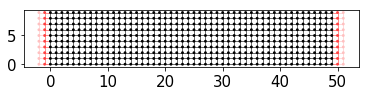

In [3]:
lat = kwant.lattice.square()

s_0 = np.identity(2)
s_z = np.array([[1, 0], [0, -1]])
s_x = np.array([[0, 1], [1, 0]])
s_y = np.array([[0, -1j], [1j, 0]])

def onsite(site, p):
    x = site.pos[0]
    if x > W and x < 2*W:
        return 4*s_0 + p.Exc*s_z
    if x > 3*W and x < 4*W:
        return 4*s_0 + p.Exc*cos(p.angle)*s_z + p.Exc*sin(p.angle)*s_x
    return 4*s_0

W = 10
H = kwant.Builder()
H[(lat(x,y) for x in range(5*W) for y in range(W))] = onsite
H[lat.neighbors()] = s_0

sym = kwant.TranslationalSymmetry(lat.vec((1,0)))

Hlead =kwant.Builder(sym)
Hlead[(lat(0,y) for y in range(W))] = 4*s_0
Hlead[lat.neighbors()] = s_0

H.attach_lead(Hlead)
H.attach_lead(Hlead.reversed())

kwant.plot(H);

In order to visualize the potential, it can be useful to have color maps of it.

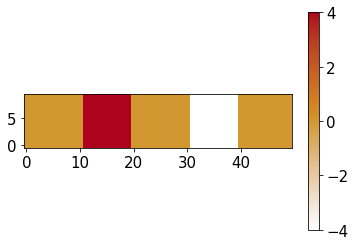

In [5]:
ps = SimpleNamespace(Exc=2., E=1.2, angle=pi)

def V(site):
    Hd = onsite(site,ps)
    return (Hd[0,0] - Hd[1,1]).real

kwant.plotter.map(H, V);

Now let us compute the angular magneto-resistance.
Try playing with the parameters, what do you observe? Do you understand why?
Is there anything wrong with our model?

/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/kwant/solvers/common.py:164: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  params=params)[:2]
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/kwant/solvers/common.py:191: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  prop, stab = lead.modes(energy, args, params=params)
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/kwant/system.py:305: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary

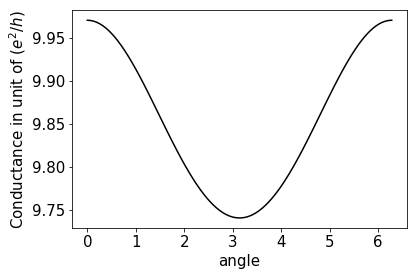

In [6]:
Hf = H.finalized()

data = []
angles = np.linspace(0,2*pi,100)

params = SimpleNamespace(Exc=0.2, E=2.3)
for params.angle in angles:
    smatrix = kwant.smatrix(Hf, params.E, args=[params])
    data.append(smatrix.transmission(1, 0))
    
pyplot.plot(angles, data);
pyplot.xlabel('angle')
pyplot.ylabel('Conductance in unit of $(e^2/h)$');

# Magnetic texture : the example of a skyrmion
Last, we can start playing with the magnetic texture, for instance a skyrmion as in the example below.

$$H = - t \sum_{<ij>} |i><j| + \sum_i V_i \ \ |i><i|$$

$$V_i = J \ m ( r) \cdot  \sigma $$

$$ m ( r) = \left(x/r \sin\theta \ , \ y/r \sin\theta \ ,\  \cos\theta \right) $$

$$\theta (r) = \tanh \frac{r-r_0}{\delta}$$

Another difference is that we will have 4 terminals and calculate the Hall resistance instead of the 2 terminal conductance.
This amounts to imposing the current and measuring the voltage, i.e. solving a small linear problem which is readily done with numpy.

Can you calculate the longitudinal resistance?


In [7]:
def HedgeHog(site,ps):
        x,y = site.pos
        r = ( x**2 + y**2 )**0.5
        theta = (np.pi/2)*(np.tanh((ps.r0 - r)/ps.delta) + 1)
        if r != 0:
            Ex = (x/r)*np.sin(theta)*s_x + (y/r)*np.sin(theta)*s_y + np.cos(theta)*s_z
        else:
            Ex = s_z
        return 4*s_0 + ps.Ex * Ex
       

def Lead_Pot(site,ps):
    return  4*s_0 +  ps.Ex * s_z

def MakeSystem(ps, show = False):
    H  = kwant.Builder()

    def shape_2DEG(pos):
        x,y = pos
        return  ( (abs(x) < ps.L) and (abs(y) < ps.W) ) or ( 
            (abs(x) < ps.W) and (abs(y) < ps.L))
    
    H[lat.shape(shape_2DEG,(0,0))] = HedgeHog
    H[lat.neighbors()] = -s_0
    
    # ITS LEADS 
    sym_x = kwant.TranslationalSymmetry((-1,0))
    H_lead_x = kwant.Builder(sym_x)
    shape_x = lambda pos: abs(pos[1])<ps.W and pos[0]==0 
    H_lead_x[lat.shape(shape_x,(0,0))] = Lead_Pot
    H_lead_x[lat.neighbors()] = -s_0
   
    sym_y = kwant.TranslationalSymmetry((0,-1))
    H_lead_y = kwant.Builder(sym_y)
    shape_y = lambda pos: abs(pos[0])<ps.W and pos[1]==0 
    H_lead_y[lat.shape(shape_y,(0,0))] = Lead_Pot 
    H_lead_y[lat.neighbors()] = -s_0
    
    H.attach_lead(H_lead_x)
    H.attach_lead(H_lead_y)
    H.attach_lead(H_lead_y.reversed())
    H.attach_lead(H_lead_x.reversed())
    
    if show:
        kwant.plot(H)

    return H
 

def Transport(Hf,EE,ps):
    smatrix = kwant.smatrix(Hf, energy=EE, args=[ps])
    G=np.zeros((4,4))
    for i in range(4):
        a=0
        for j in range(4): 
            G[i,j] = smatrix.transmission(i, j)
            if i != j:
                a += G[i,j]
        G[i,i] = -a 
        
    V = np.linalg.solve(G[:3,:3], [1.,0,0])
    Hall = V[2] - V[1]
    
    return G, Hall

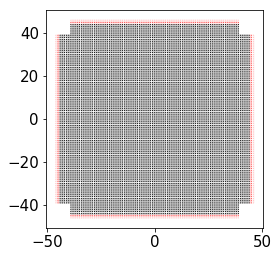

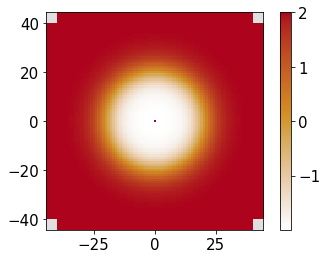

/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: The plotted data contains 0.06% of values overflowing upper limit 0.991153 and 0.06% of values underflowing lower limit -0.991153 
  from ipykernel import kernelapp as app


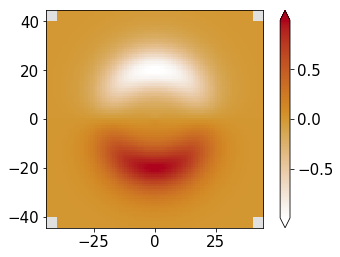

In [8]:
ps = SimpleNamespace(L=45, W=40, delta=10, r0=20, Ex=1.)

H = MakeSystem(ps, show=True)
Hf = H.finalized()

def Vz(site):
    Hd = HedgeHog(site,ps)
    return (Hd[0,0] - Hd[1,1]).real 

def Vy(site):
    Hd = HedgeHog(site, ps)
    return Hd[0,1].imag 

kwant.plotter.map(H, Vz);
kwant.plotter.map(H, Vy);

/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/kwant/solvers/common.py:164: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  params=params)[:2]
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/kwant/solvers/common.py:191: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  prop, stab = lead.modes(energy, args, params=params)
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/kwant/system.py:305: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary v

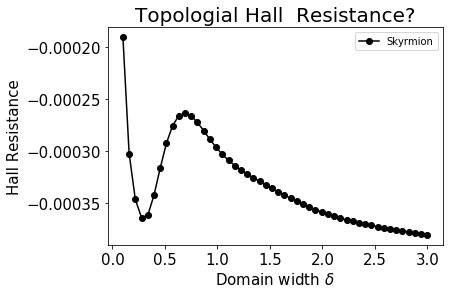

In [9]:
# HALL RESISTANCE
ps = SimpleNamespace(L=20, W=15, delta=3, r0=6, Ex=1.)

H = MakeSystem(ps, show=False)
Es = np.linspace(0.1,3.,50)
Hf = H.finalized()
dataG , dataHall = [],[]

for EE in Es: 
    ps.delta = EE
    energy = 2.
    G,Hall = Transport(Hf, energy, ps)
    dataHall.append(Hall)

pyplot.plot(Es, dataHall, 'o-', label="Skyrmion")
pyplot.xlabel('Domain width $\delta$')
pyplot.ylabel('Hall Resistance')
pyplot.title('Topologial Hall  Resistance?')
pyplot.legend();